<a href="https://colab.research.google.com/github/iksnn/Learn-Basic-Deep-Learning/blob/main/Emotion_Recognition_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Description:

**Introduction**

Welcome to the "Emotions" dataset – a collection of English Twitter messages meticulously annotated with six fundamental emotions: anger, fear, joy, love, sadness, and surprise. This dataset serves as a valuable resource for understanding and analyzing the diverse spectrum of emotions expressed in short-form text on social media.

**About Dataset**

Each entry in this dataset consists of a text segment representing a Twitter message and a corresponding label indicating the predominant emotion conveyed. The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5). Whether you're interested in sentiment analysis, emotion classification, or text mining, this dataset provides a rich foundation for exploring the nuanced emotional landscape within the realm of social media.

**Key Features**

text: A string feature representing the content of the Twitter message.
label: A classification label indicating the primary emotion, with values ranging from 0 to 5.


In [ ]:
import os
os.chdir("/content/drive/MyDrive/MSIB Celerates Batch 7/Code Ipynb/43. Emotion Recognition")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras import Model

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv("text.csv")
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Assuming 'label' is the column containing the emotion labels
X = df.drop('label', axis=1)  # Features (text data)
y = df['label']  # Target (emotion labels)

rus = RandomUnderSampler(sampling_strategy={i: 10000 for i in y.unique()}, random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Create a new DataFrame with the resampled data
df = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60000 entries, 133243 to 413061
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  60000 non-null  int64 
 1   text        60000 non-null  object
 2   label       60000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.8+ MB


In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
text,0
label,0


In [ ]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df['label'].value_counts()

,count
label,
0,10000
1,10000
2,10000
3,10000
4,10000
5,10000


In [ ]:
stop_words = stopwords.words('english')

def data_cleaning(text):

    # Convert to lower
    text = text.lower()

    remove_stopwords = [word for word in text.split() if word not in stop_words]
    text = ' '.join(remove_stopwords)

    # Remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove digits
    text = re.sub(r"\d", '', text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)

    return text

In [ ]:
df['cleaned_text'] = df['text'].apply(data_cleaning)

# Modeling

In [ ]:
X = df['cleaned_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
max_length = df['cleaned_text'].apply(lambda x: len(str(x).split())).max()

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

X_train.shape, X_test.shape

((48000, 39), (12000, 39))

In [ ]:
y_train = pd.get_dummies(y_train, dtype=int)
y_test = pd.get_dummies(y_test, dtype=int)

In [ ]:
GLOVE_EMB = 'glove.6B.300d.txt'

embeddings_index = {}

f = open(GLOVE_EMB , encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

#embeddings_index['the']

EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

Found 400000 word vectors.


In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

embedding_layer = Embedding(
    vocab_size,
    EMBEDDING_DIM,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_length,
    trainable=False)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
sequence_input = Input(shape=(X_train.shape[1],))
embedding_sequences = embedding_layer(sequence_input)

x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(embedding_sequences)
outputs = Dense(6, activation='softmax')(x)

model = Model(sequence_input, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 39)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 39, 300)             │       8,952,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │         186,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,139,654 (34.87 MB)

 Trainable params: 187,654 (733.02 KB)

 Non-trainable params: 8,952,000 (34.15 MB)

In [ ]:
history = model.fit(X_train , y_train, batch_size = 512, validation_split=0.2, epochs=5)

Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 46s 561ms/step - accuracy: 0.3655 - loss: 1.5950 - val_accuracy: 0.6810 - val_loss: 0.9132
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 549ms/step - accuracy: 0.6876 - loss: 0.8845 - val_accuracy: 0.8073 - val_loss: 0.5705
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 84s 584ms/step - accuracy: 0.7918 - loss: 0.6095 - val_accuracy: 0.8641 - val_loss: 0.4157
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 86s 634ms/step - accuracy: 0.8429 - loss: 0.4642 - val_accuracy: 0.8875 - val_loss: 0.3389
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 48s 639ms/step - accuracy: 0.8747 - loss: 0.3715 - val_accuracy: 0.9029 - val_loss: 0.2911


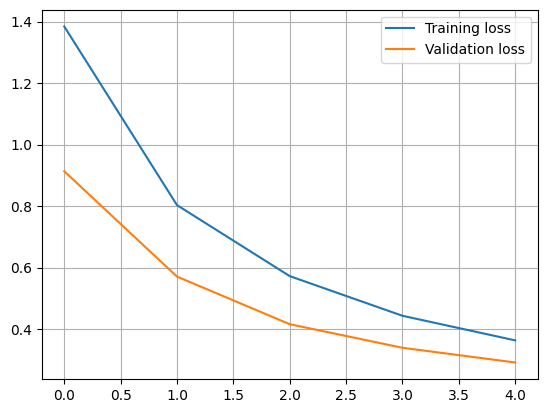

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")

plt.legend()
plt.grid()
plt.show()

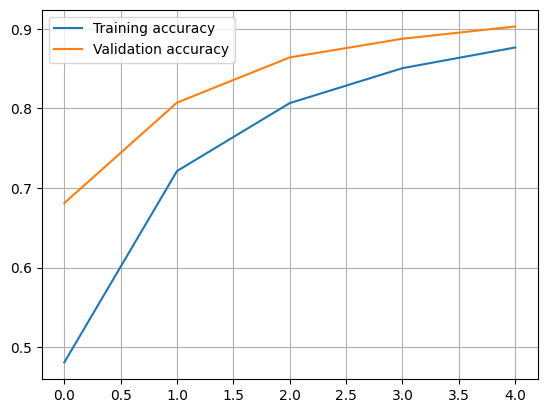

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(accuracy, label="Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")

plt.legend()
plt.grid()
plt.show()

In [ ]:
predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis=1)

# Convert y_test from one-hot encoded format like [0 0 1 0 0 0] to categorical labels by selecting the index with the highest value
y_test = np.argmax(y_test, axis=1)

print(accuracy_score(y_pred, y_test))

375/375 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step
0.90325


In [ ]:
comparison_df = pd.DataFrame()
comparison_df['y_pred'] = y_pred
comparison_df['y_test'] = y_test

comparison_df['y_pred'] = comparison_df['y_pred'].map({0:'sadness', 1:'joy', 2:'love', 3:'anger',4:'fear', 5: 'surprise'})
comparison_df['y_test'] = comparison_df['y_test'].map({0:'sadness', 1:'joy', 2:'love', 3:'anger',4:'fear', 5: 'surprise'})

# Print first 10 predicted and true labels to have a look.
comparison_df[:10]

,y_pred,y_test
0,joy,joy
1,sadness,sadness
2,anger,anger
3,surprise,surprise
4,surprise,surprise
5,surprise,surprise
6,love,love
7,joy,joy
8,joy,joy
9,sadness,sadness
